In [2]:
import pandas as pd
df = pd.read_csv("../data/complete_eminem.csv")
df.head()

,track_name,album_name,year,corpus
0,The Ringer,Kamikaze,2018,"Yeah, (Illa)\nYo, I'm just gonna write down my..."
1,Fall,Kamikaze,2018,"You know, everybody's been tellin' me\nwhat th..."
2,Kamikaze,Kamikaze,2018,"Okay, how do I say this? (Fack, fack, fack)\nL..."
3,Greatest,Kamikaze,2018,"Motherfuckers talkin' crazy (yeah) , sayin' I ..."
4,Nice Guy,Kamikaze,2018,"You're such a nice guy, a nice guy\nYou're fai..."


# Remove Stopwords

In [5]:
from nltk.corpus import stopwords
def remove_stopwords(text):
    text = text.split(' ')
    text = [x for x in text if x not in stopwords.words('english')]
    return ' '.join(text)

df.loc[:, 'corpus'] = df.loc[:, 'corpus'].apply(lambda x: remove_stopwords(x))

# Remove Ponctuations

In [7]:
import re
def remove_ponctuation(text):
    return  " ".join(re.findall("[a-zA-Z]+", text))

df.loc[:, 'corpus'] = df.loc[:, 'corpus'].apply(lambda x: remove_ponctuation(x))

# Remove words with less thant 3 chars

In [8]:
def remove_words_with_less_3(text):
    text = text.split(' ')
    text = [x for x in text if len(x)>3]
    return ' '.join(text)

df.loc[:, 'corpus'] = df.loc[:, 'corpus'].apply(lambda x: remove_words_with_less_3(x))

# Everybody Down! (to lowercase)

In [9]:
df.loc[:, 'corpus'] = df.loc[:, 'corpus'].apply(lambda x: x.lower())
df['word count'] = df['corpus'].apply(lambda x: len(x.split(' ')))

# Word Count

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

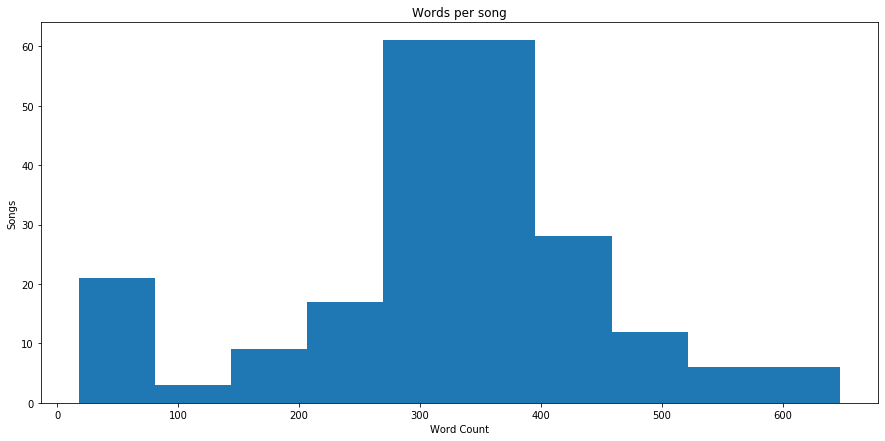

In [12]:
figure(figsize=(15,7))
(n, bins, patches) = plt.hist(df['word count'], 10)

plt.xlabel('Word Count')
plt.ylabel('Songs')
plt.title('Words per song')

_ = plt.show()

In [ ]:
# Unique Words

In [71]:
len(set([token.text for token in doc if token.text]))

AttributeError: 'str' object has no attribute 'text'

# Most popular Words

In [14]:
popular_words = dict()

l = []
for row in df.iterrows():
    l += row[1]['corpus'].split(' ')
    
for word in l:
    if word not in popular_words.keys():
        popular_words[word] = 1
    else:
        popular_words[word] += 1

popular_words_x = sorted(popular_words, key=popular_words.get,reverse=True)[:10][::-1]
popular_words_y = [popular_words.get(key) for key in sorted(popular_words, key=popular_words.get, reverse=True)[:10]][::-1]

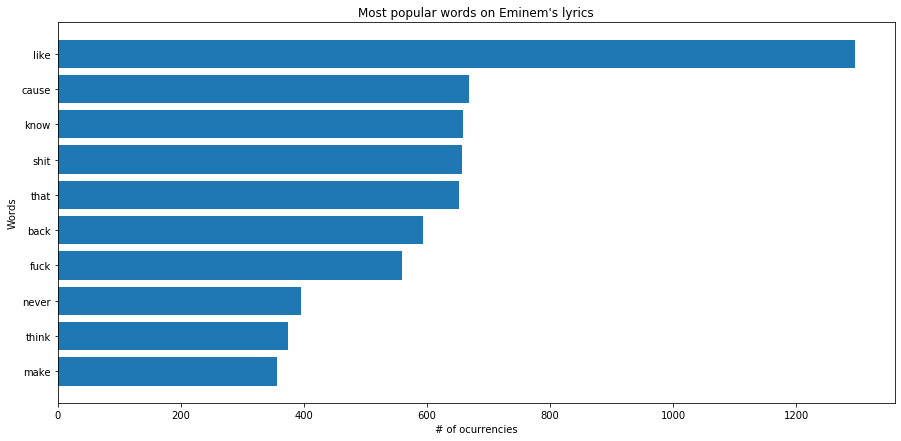

In [16]:
figure(figsize=(15,7))
plt.barh(popular_words_x, popular_words_y)

plt.title("Most popular words on Eminem's lyrics")
plt.xlabel('# of ocurrencies')
plt.ylabel('Words')


plt.show()

# Most Popular Words by Album/Year

In [20]:
len(df.album_name.unique())

16

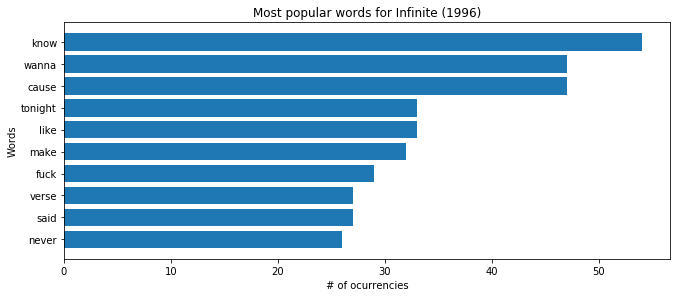

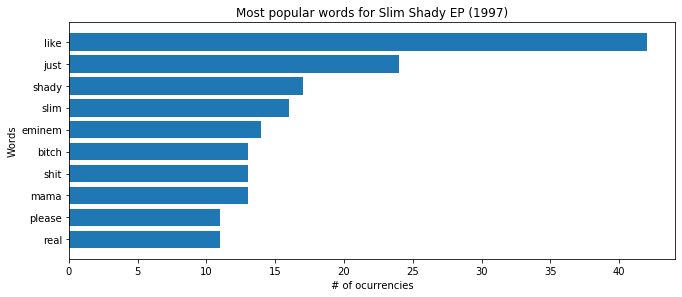

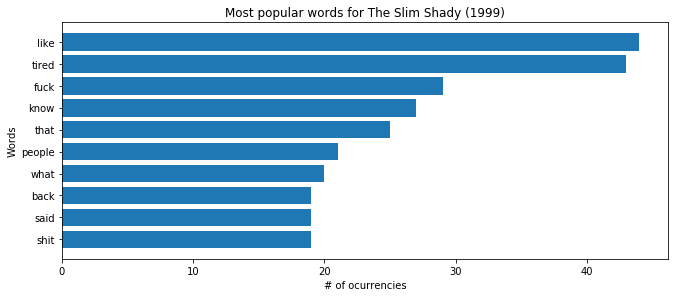

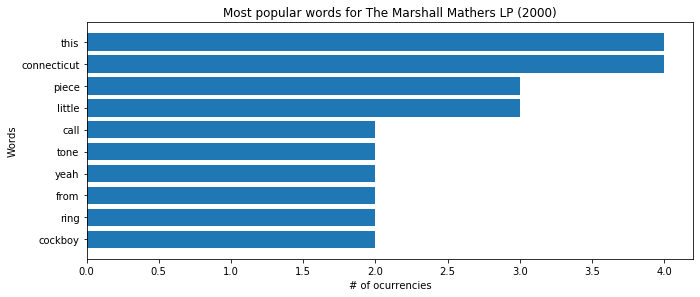

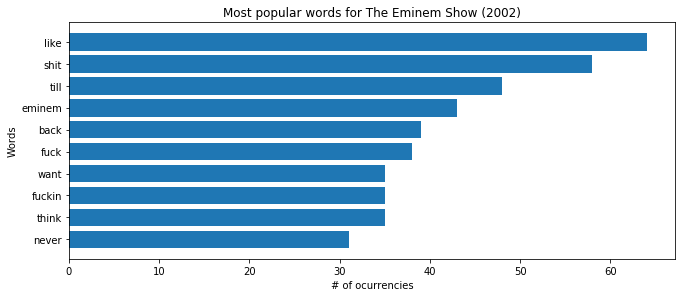

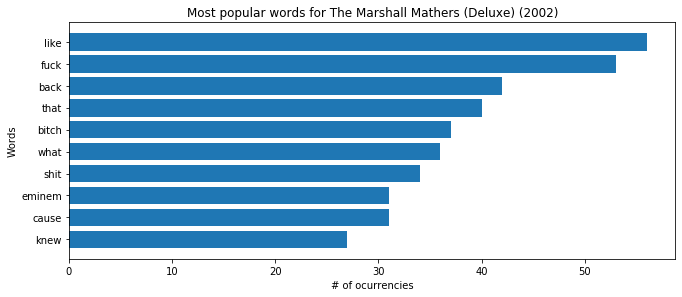

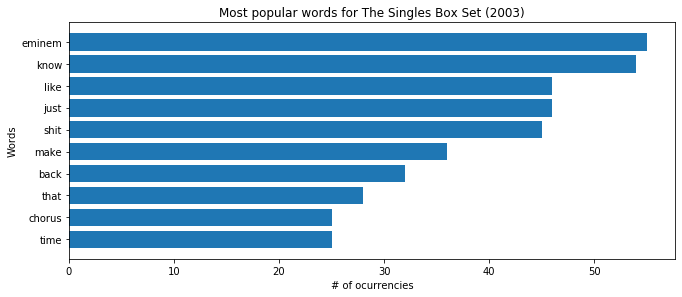

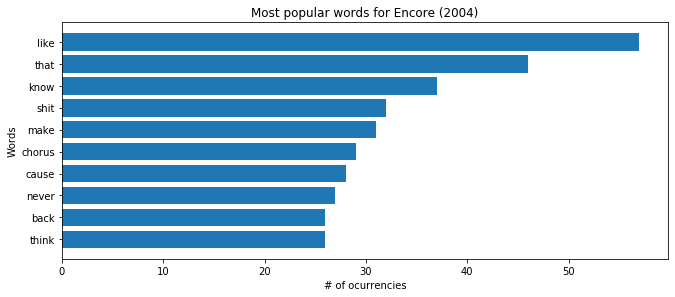

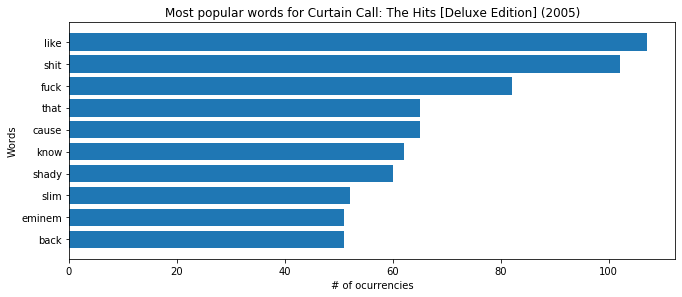

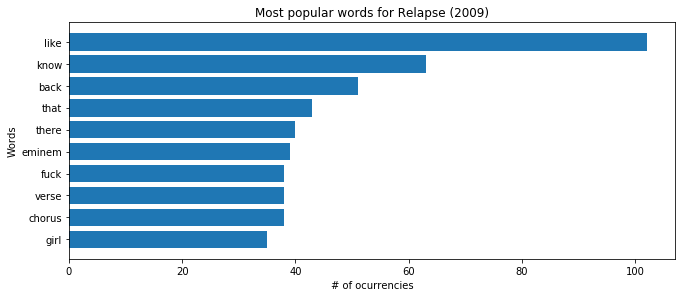

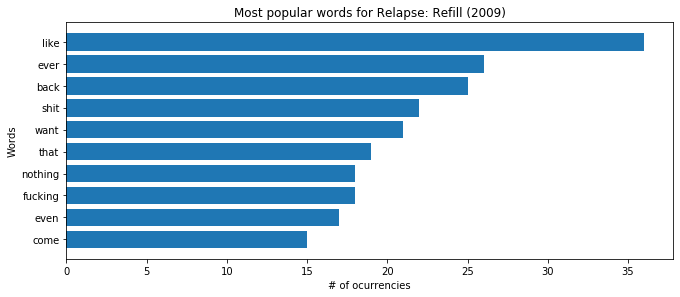

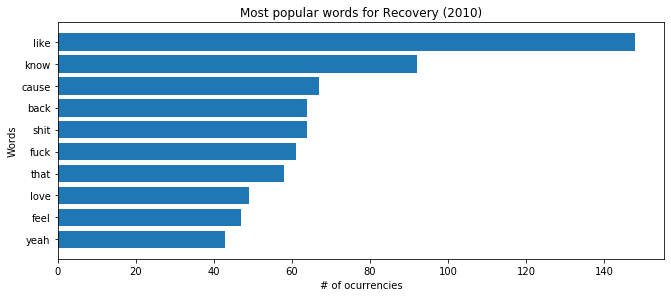

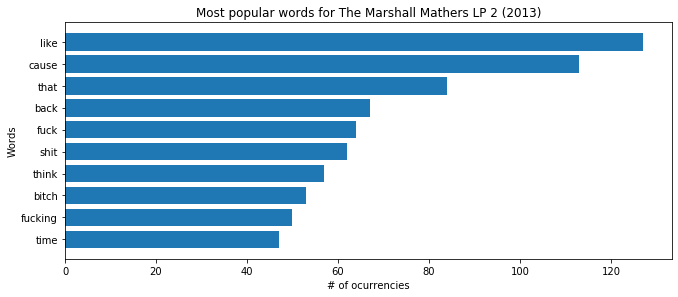

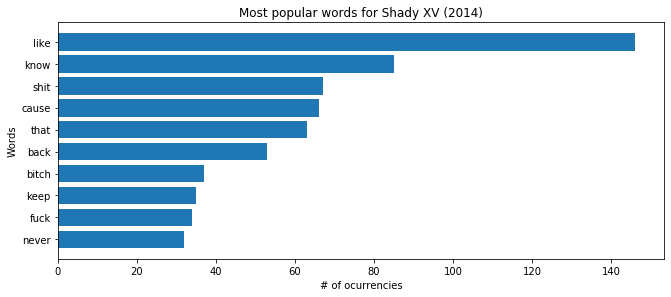

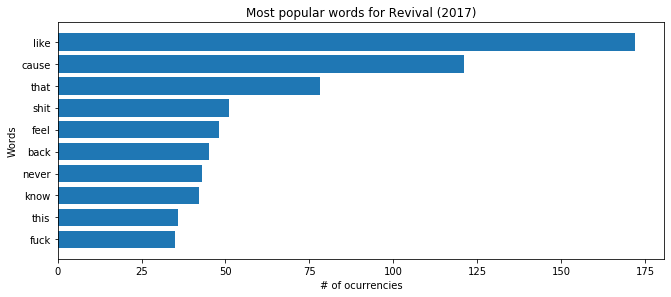

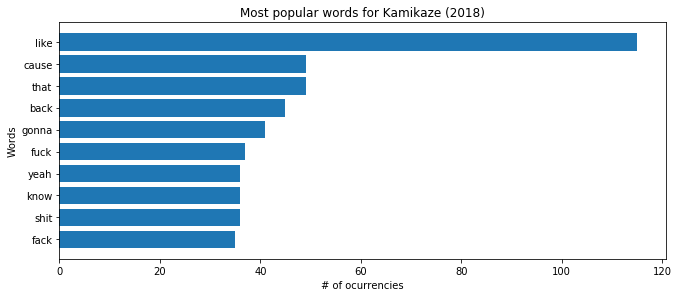

In [34]:
for i, ((year, album), subdf) in enumerate(df.groupby(["year", "album_name"])):
    album_corpora = list(subdf.corpus.values)
    words = dict()
    for word in " ".join(album_corpora).split(" "):
        words[word] = words.get(word, 0) + 1

    most_popular_x = sorted(words, key=words.get, reverse=True)[:10][::-1]
    most_popular_y = [words[word] for word in most_popular_x]

    figure(figsize=(50,20))

    plt.subplot(4, 4, i+1)
    plt.barh(most_popular_x, most_popular_y)
    plt.title("Most popular words for {} ({})".format(album, year))
    plt.xlabel('# of ocurrencies')
    plt.ylabel('Words')



# TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [48]:
docs = list()
for i, ((year, album), subdf) in enumerate(df.groupby(["year", "album_name"])):
    album_corpora = " ".join(list(subdf.corpus.values))
    docs.append(album_corpora)
    
tfidf = TfidfVectorizer()
response = tfidf.fit_transform(docs)
    
scores = zip(tfidf.get_feature_names(), np.asarray(response.sum(axis=0)).ravel())

sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
sorted_scores[:10]

[('like', 4.586752010587703),
 ('that', 2.2670687881773897),
 ('shit', 2.2515541417790703),
 ('know', 2.2312685838979975),
 ('cause', 2.167312735526001),
 ('back', 2.1441272172173407),
 ('fuck', 1.905673135194587),
 ('never', 1.4015137589289577),
 ('eminem', 1.347674879478514),
 ('think', 1.317619676150418)]

# TF-IDF Álbum

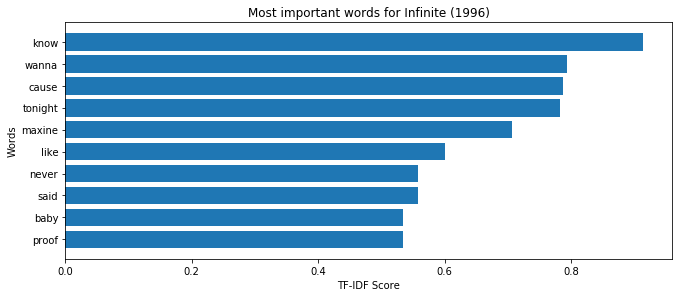

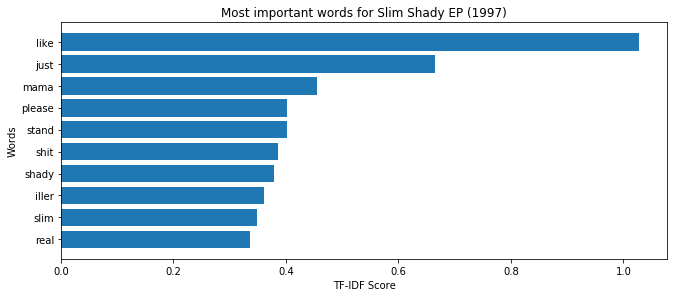

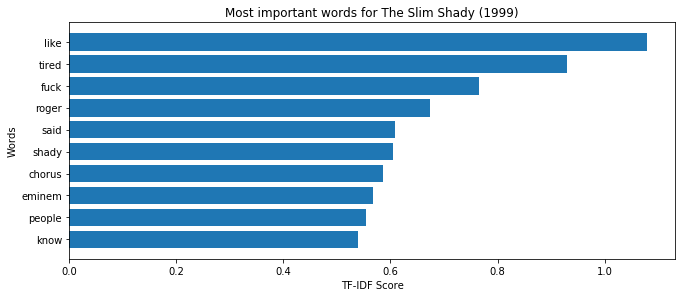

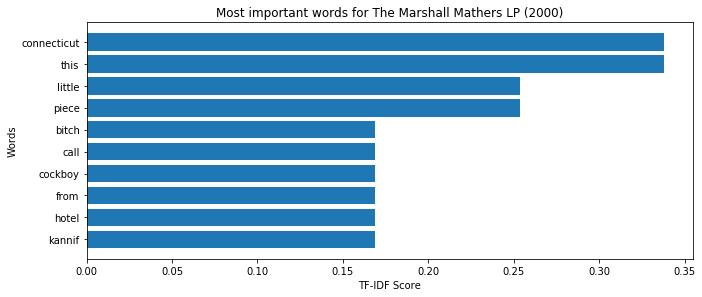

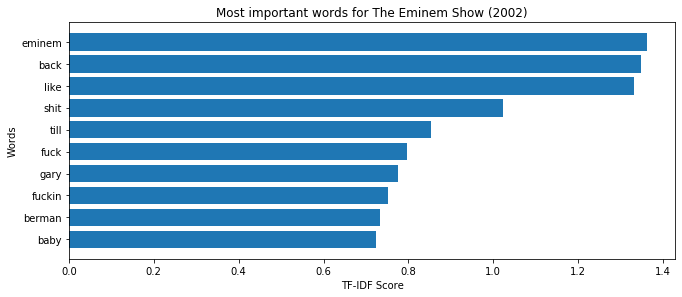

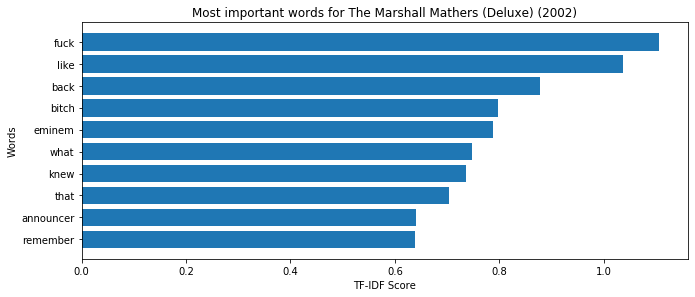

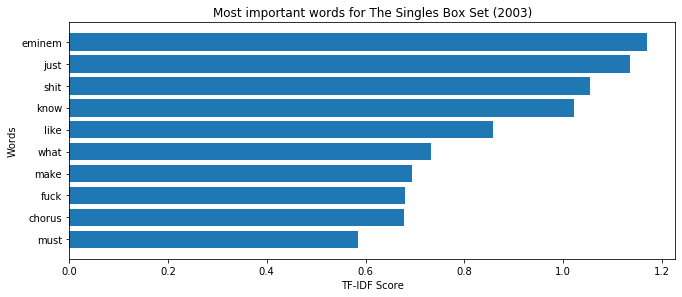

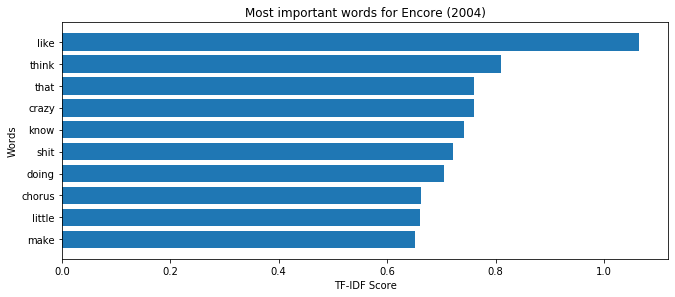

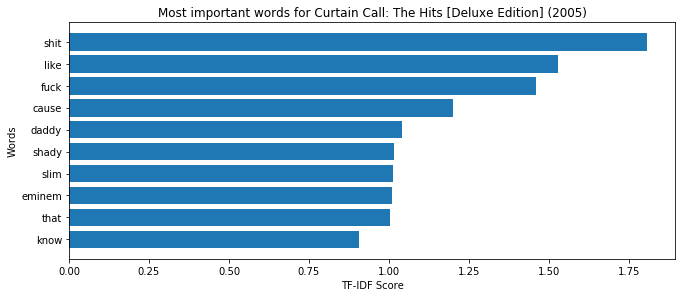

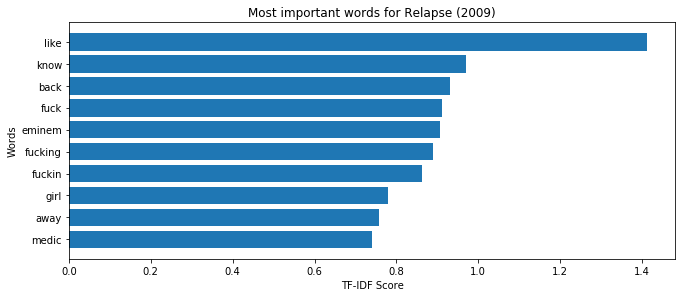

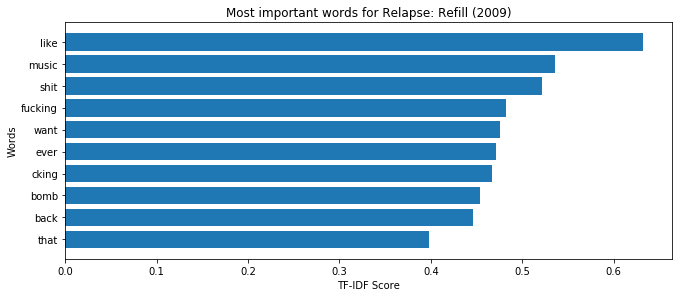

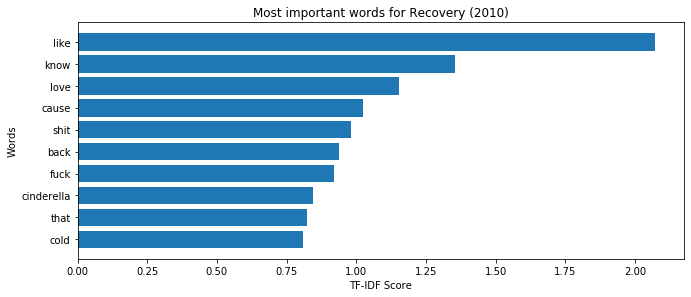

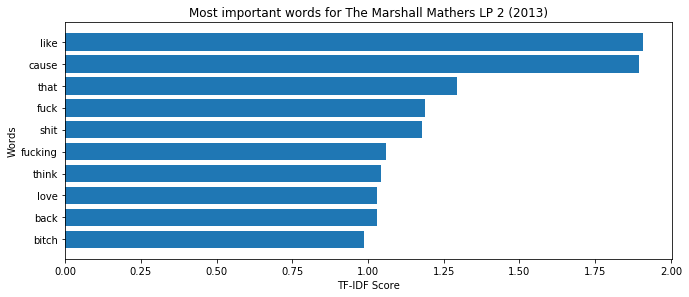

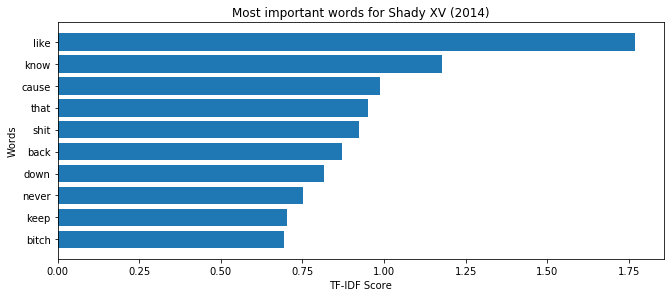

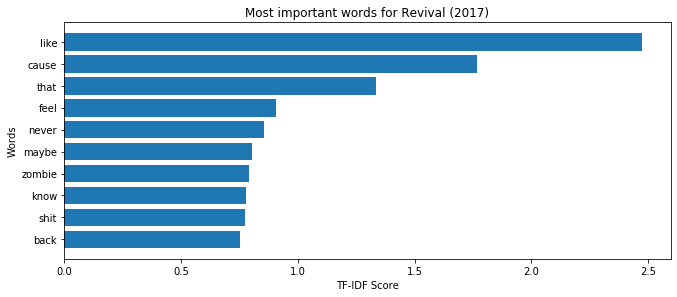

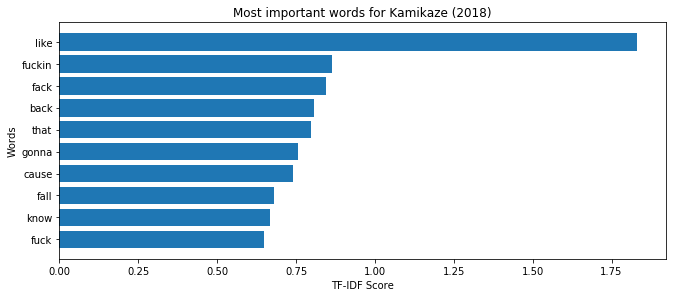

In [55]:
for i, ((year, album), subdf) in enumerate(df.groupby(["year", "album_name"])):
    album_corpora = list(subdf.corpus.values)
    tfidf = TfidfVectorizer()
    response = tfidf.fit_transform(album_corpora)
    scores = zip(tfidf.get_feature_names(), np.asarray(response.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    sorted_scores[:10]
    
    figure(figsize=(50,20))

    plt.subplot(4, 4, 1)
    plt.barh([x[0] for x in sorted_scores[:10]][::-1], [x[1] for x in sorted_scores[:10]][::-1])
    plt.title("Most important words for {} ({})".format(album, year))
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Words')

# NRC

In [64]:
df_nrc = pd.read_csv('../data/NRC.tsv', sep='\t',  names=['Sentiment', 'Filter', 'Score'])
df_nrc.head()

,Sentiment,Filter,Score
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


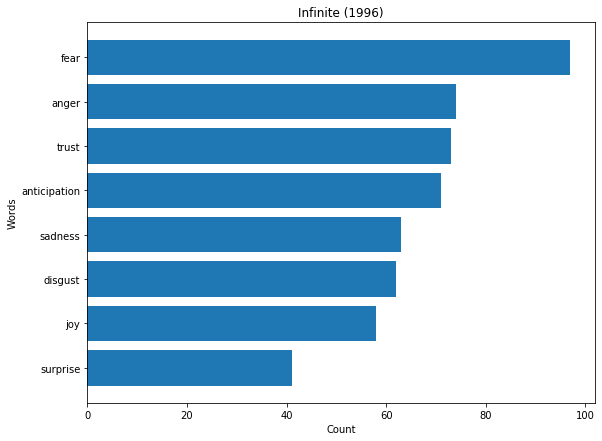

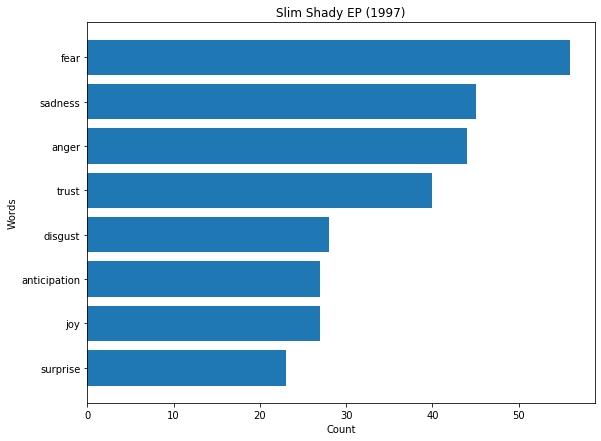

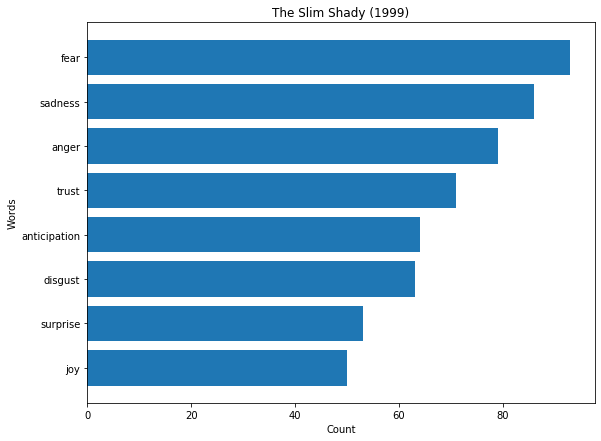

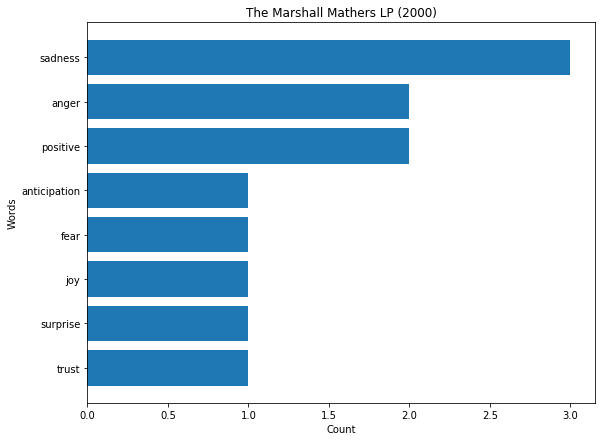

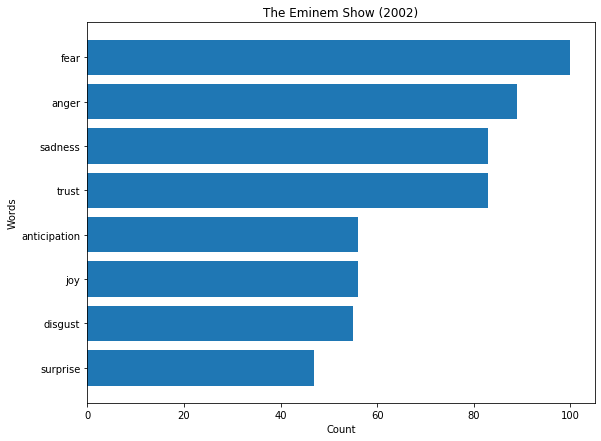

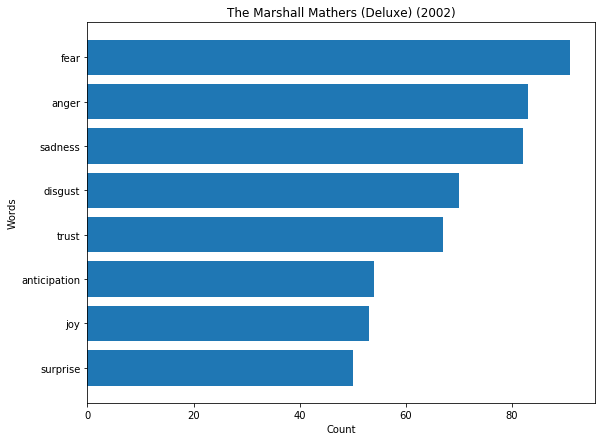

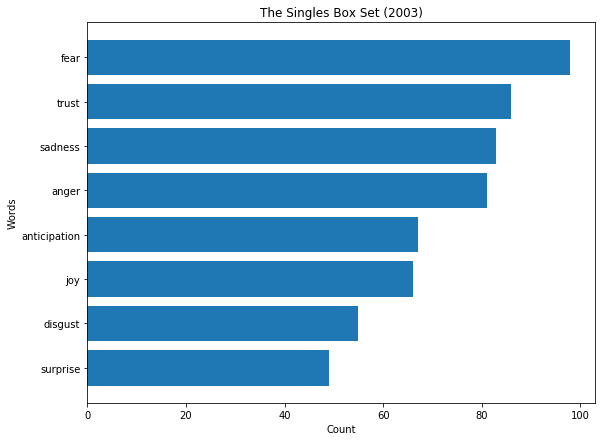

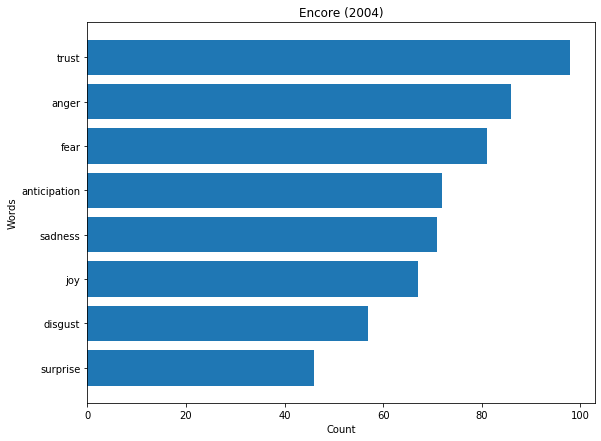

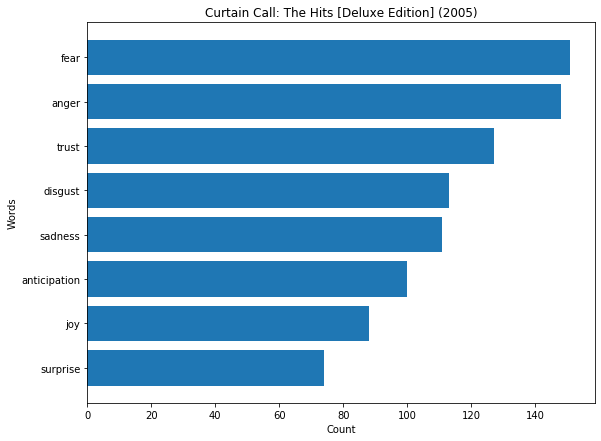

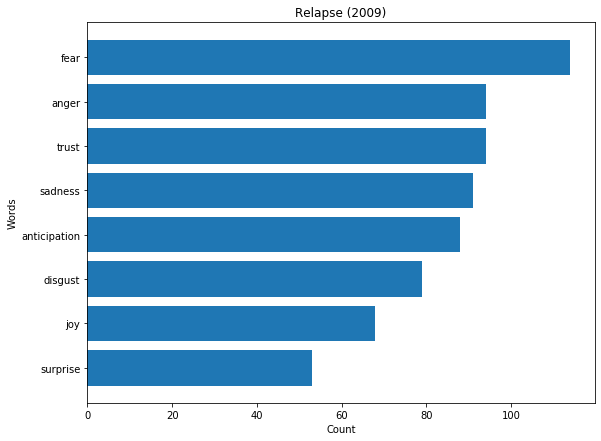

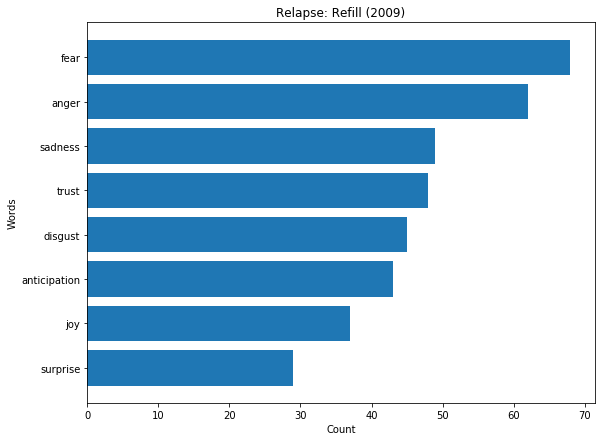

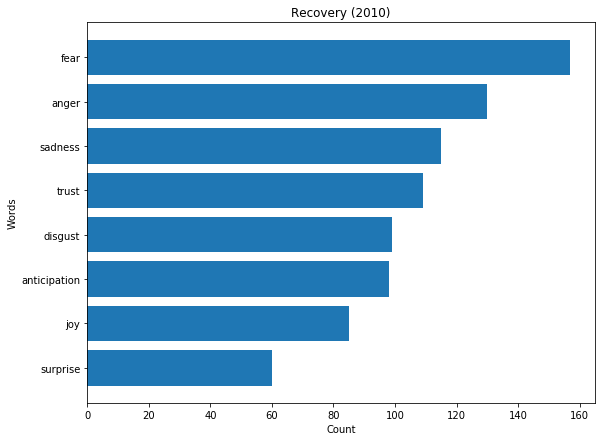

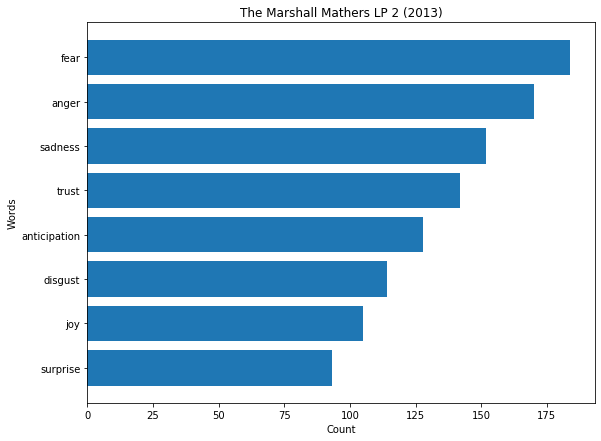

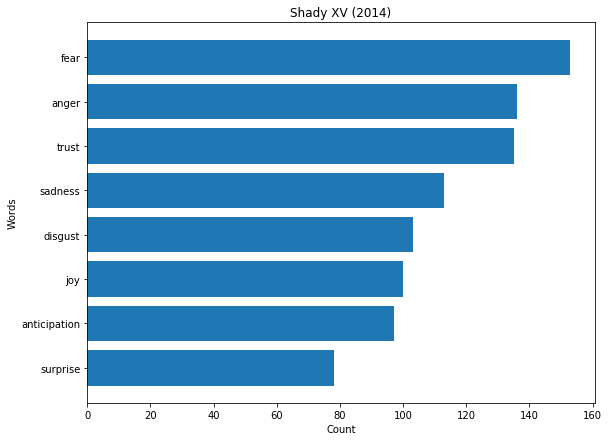

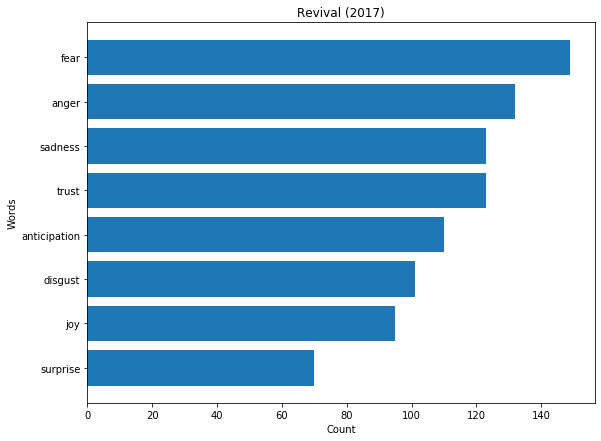

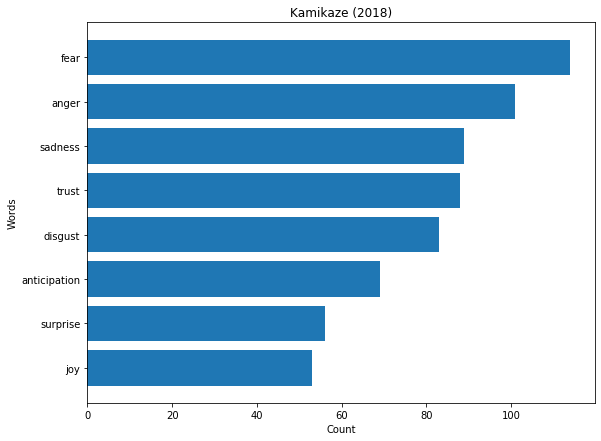

In [66]:
set_of_nrc_words = df_nrc.loc[:, 'Sentiment'].unique()

for i, ((year, album), subdf) in enumerate(df.groupby(["year", "album_name"])):
    album_corpora = list(subdf.corpus.values)
    set_of_nrc_words_album = set(" ".join(album_corpora).split(" ")).intersection(set(set_of_nrc_words))
    
    nrc_score_album = df_nrc[(df_nrc['Sentiment'].isin(set_of_nrc_words_album)) & (df_nrc['Score'] == 1)].groupby(['Filter']).sum()
    nrc_score_album = nrc_score_album.sort_values(by='Score', ascending=False).iloc[2:, :]
    
    figure(figsize=(20,7))

    plt.subplot(1, 2, 1)
    plt.barh(nrc_score_album.index[::-1], [value[0] for value in nrc_score_album.values][::-1])
    plt.title("{} ({})".format(album, year))
    plt.xlabel('Count')
    plt.ylabel('Words')


# NRC for Positive/Negative

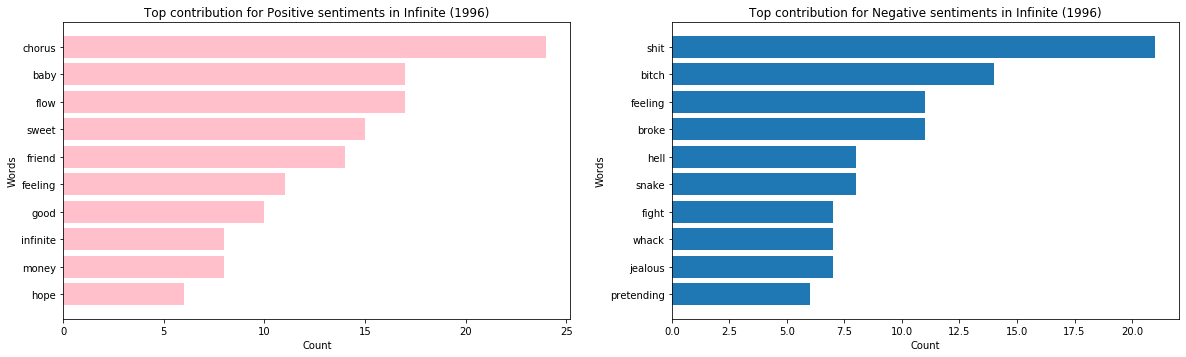

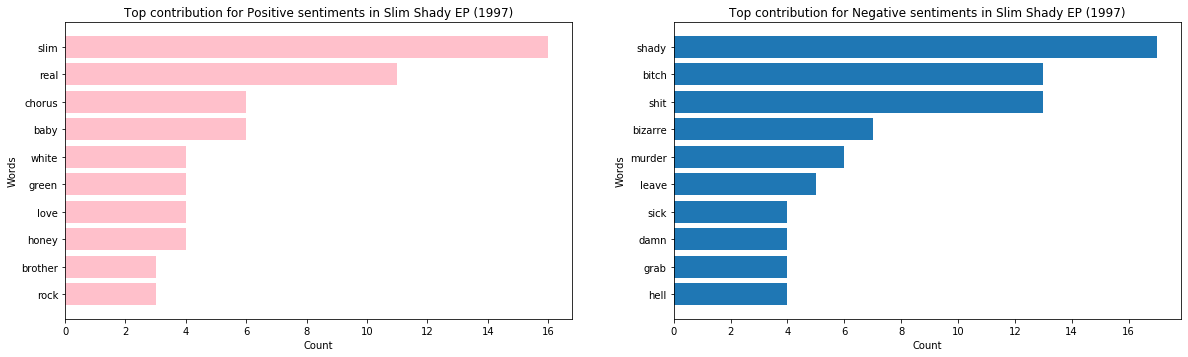

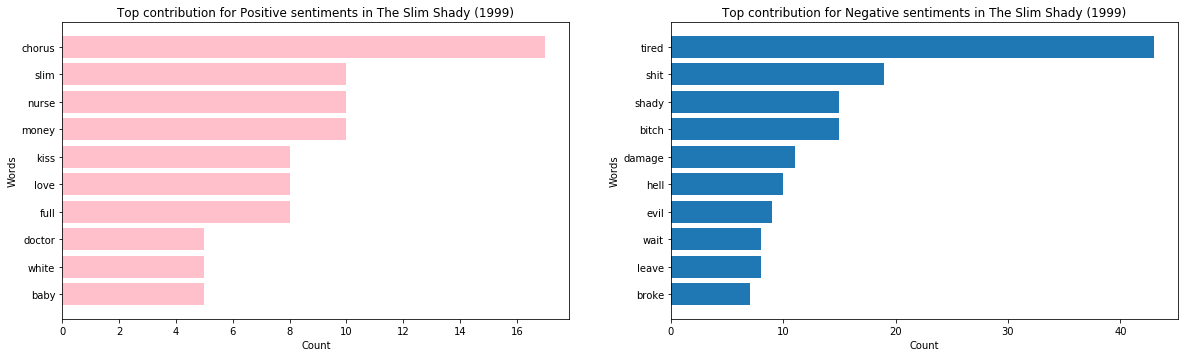

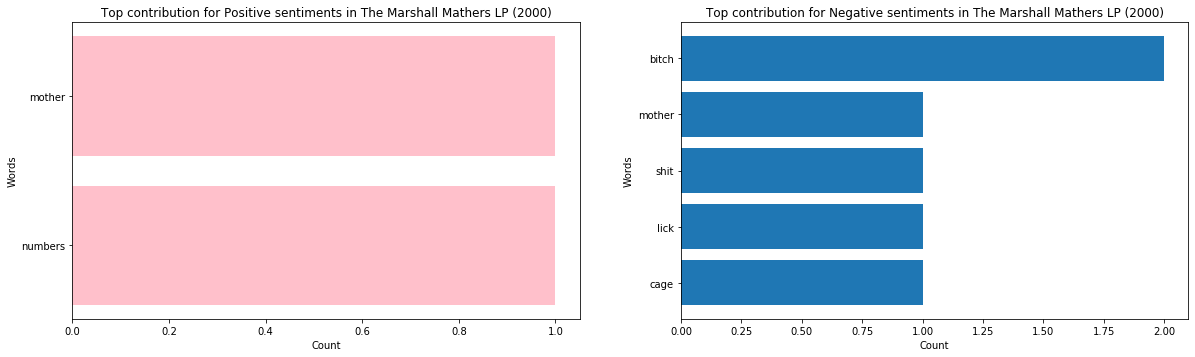

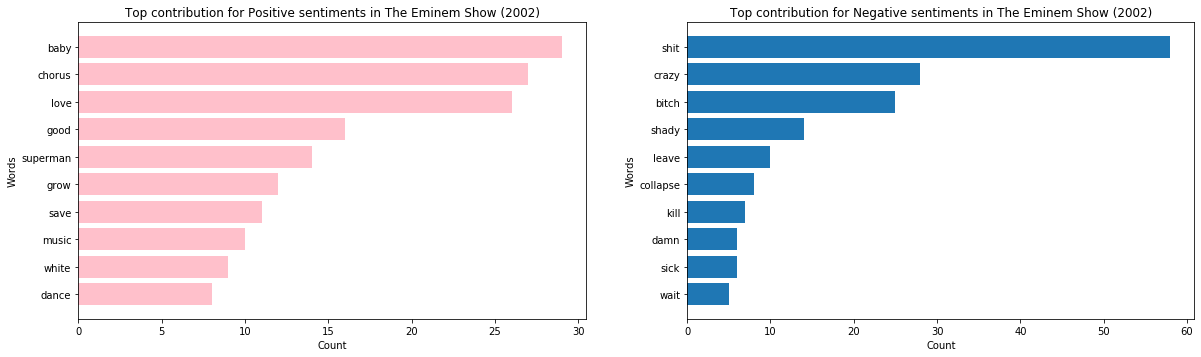

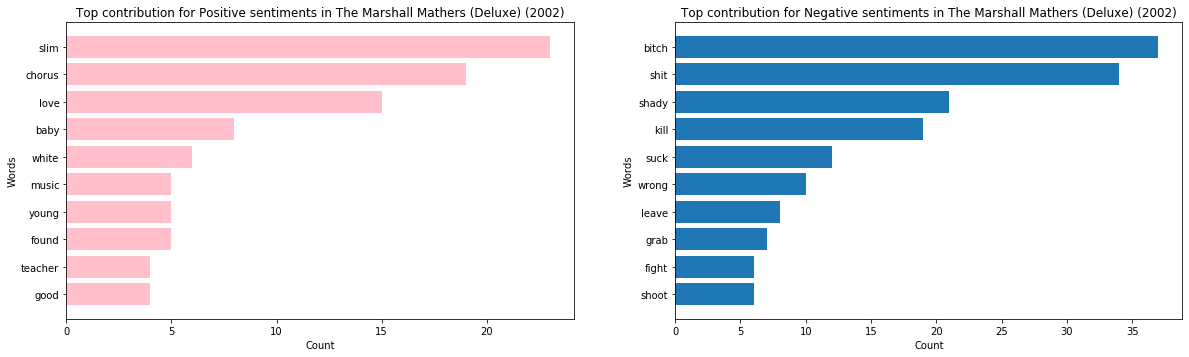

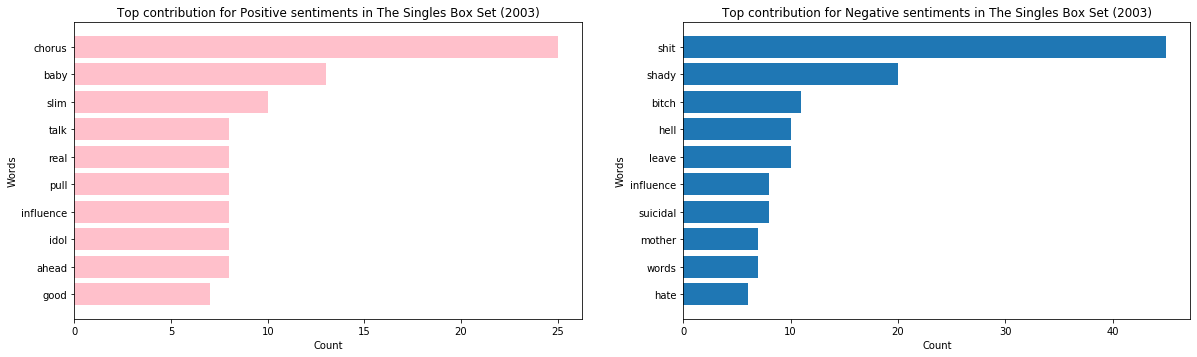

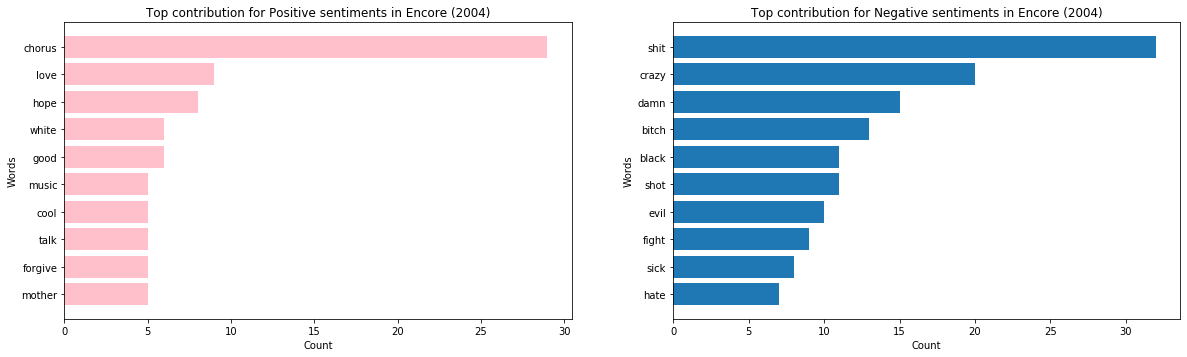

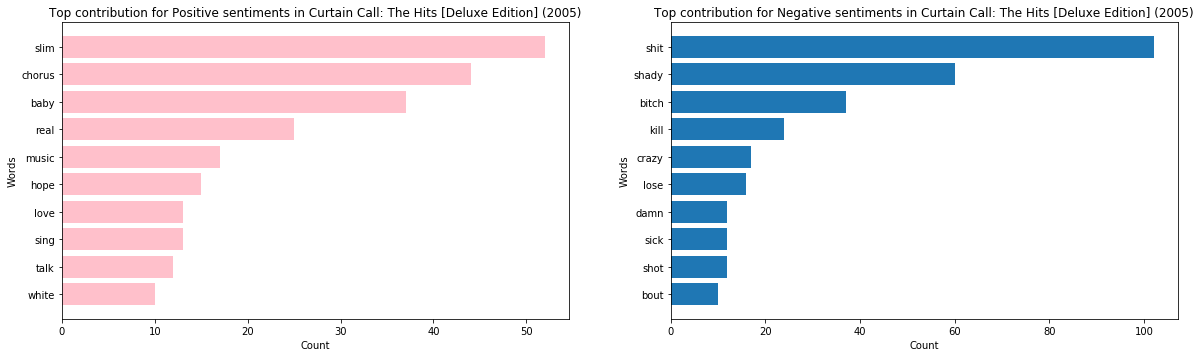

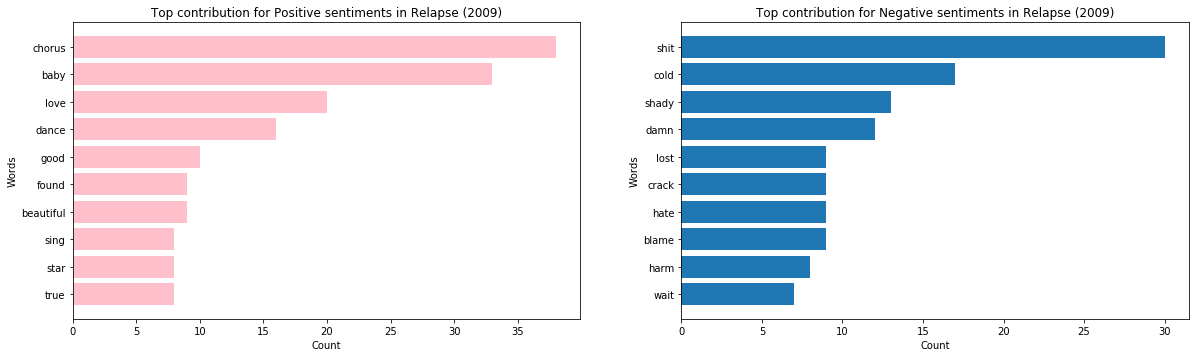

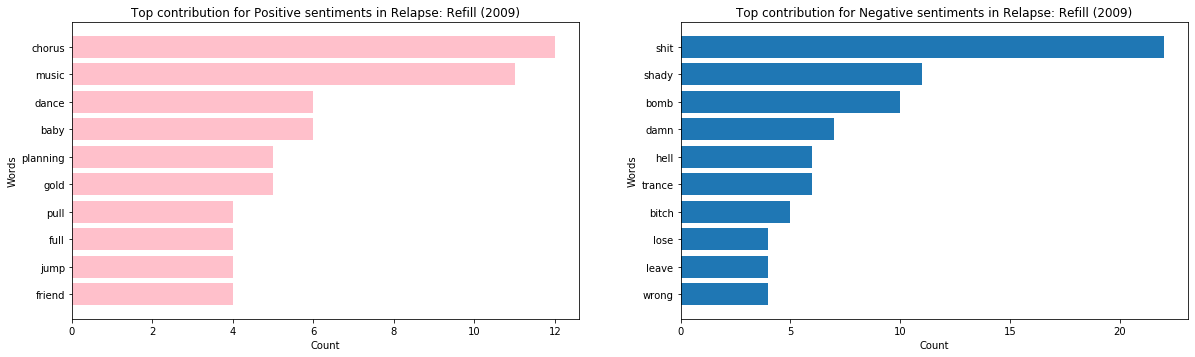

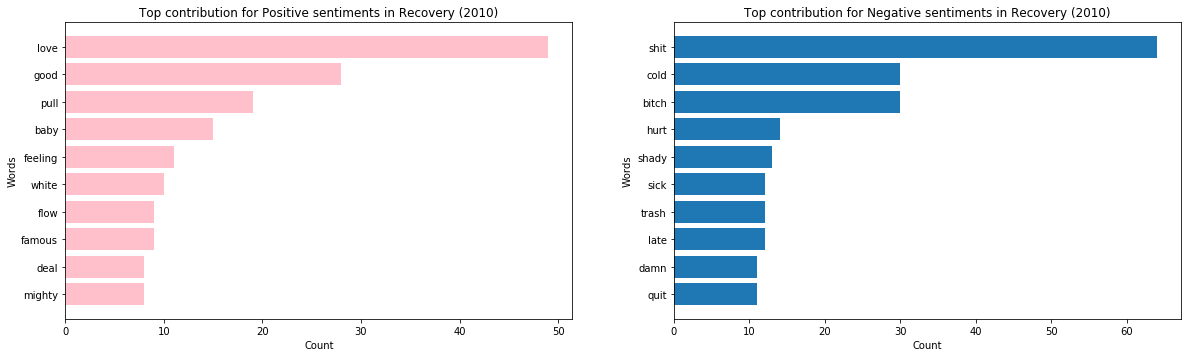

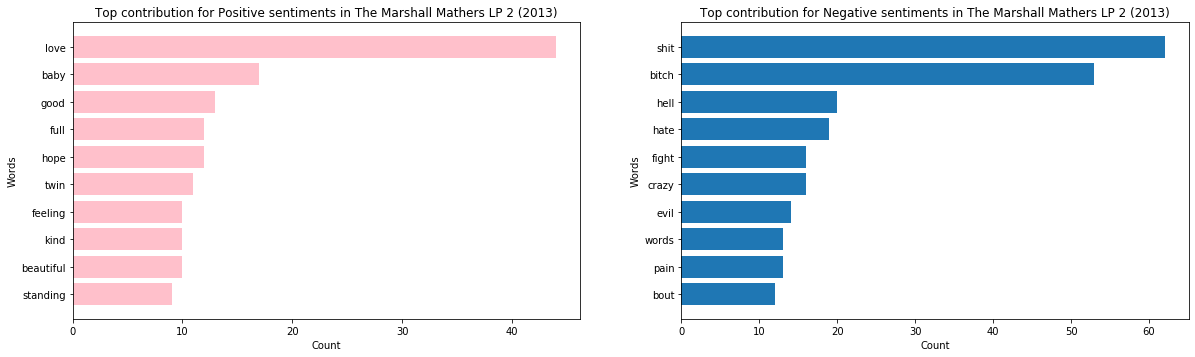

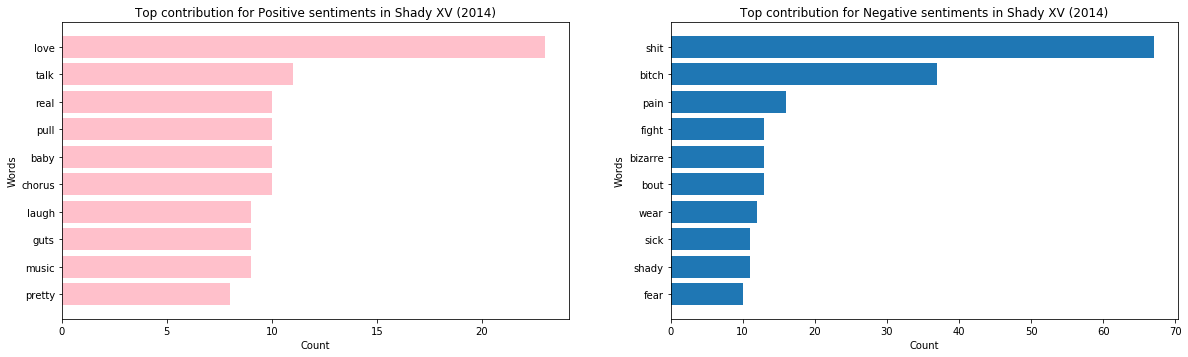

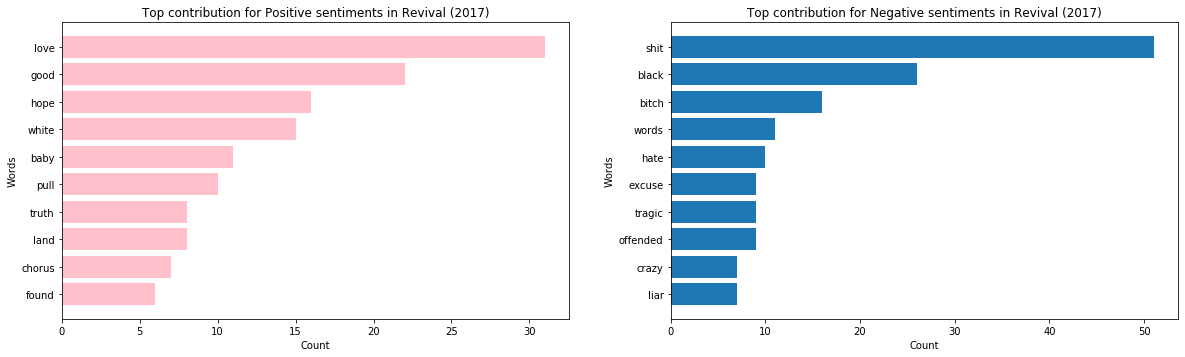

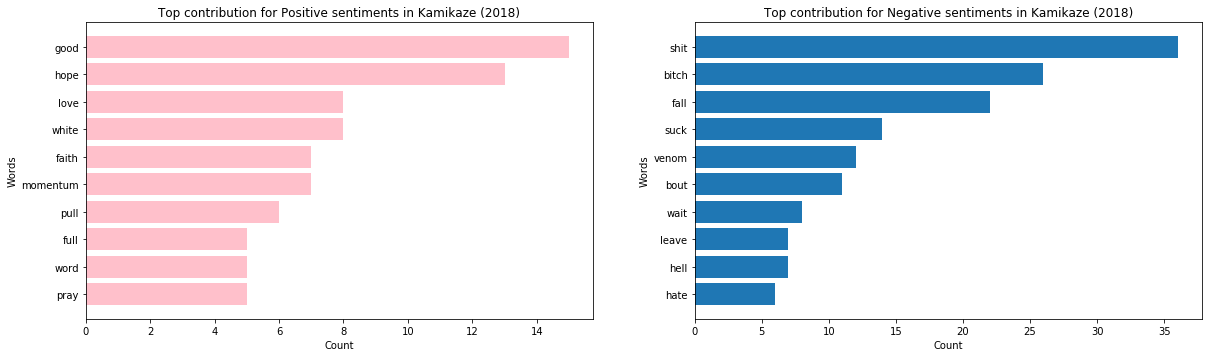

In [69]:
set_of_nrc_words = df_nrc.loc[:, 'Sentiment'].unique()

for i, ((year, album), subdf) in enumerate(df.groupby(["year", "album_name"])):
    album_corpora = list(subdf.corpus.values)
    set_of_nrc_words_album = set(" ".join(album_corpora).split(" ")).intersection(set(set_of_nrc_words))
    
    nrc_score_album = df_nrc[(df_nrc['Sentiment'].isin(set_of_nrc_words_album)) & (df_nrc['Score'] == 1)].groupby(['Filter']).sum()
    nrc_score_album = nrc_score_album.sort_values(by='Score', ascending=False).iloc[2:, :]
    
    words_for_positive_sentiments_album = df_nrc[\
       (df_nrc['Sentiment'].isin(set_of_nrc_words_album)) & \
       (df_nrc['Score'] == 1) & \
       (df_nrc['Filter'] == 'positive')].loc[:, 'Sentiment'].values

    words_for_negative_sentiments_album = df_nrc[\
       (df_nrc['Sentiment'].isin(set_of_nrc_words_album)) & \
       (df_nrc['Score'] == 1) & \
       (df_nrc['Filter'] == 'negative')].loc[:, 'Sentiment'].values
    
    positive_count_album = dict()
    negative_count_album = dict()
    
    for word in ' '.join(album_corpora).split(' '):
        if word in words_for_positive_sentiments_album:
            if word in positive_count_album.keys():
                positive_count_album[word]+=1
            else:
                positive_count_album[word] = 1
            
    for word in ' '.join(album_corpora).split(' '):
        if word in words_for_negative_sentiments_album:
            if word in negative_count_album.keys():
                negative_count_album[word]+=1
            else:
                negative_count_album[word] = 1
    
    
    positive_x_album = sorted(positive_count_album, key=positive_count_album.get, reverse=True)[:10]
    positive_y_album = [positive_count_album.get(key) for key in sorted(positive_count_album, key=positive_count_album.get, reverse=True)][:10]

    negative_x_album = sorted(negative_count_album, key=negative_count_album.get, reverse=True)[:10]
    negative_y_album = [negative_count_album.get(key) for key in sorted(negative_count_album, key=negative_count_album.get, reverse=True)][:10]

    
    figure(figsize=(20,12))
    
    plt.subplot(2, 2, 1)
    plt.barh(positive_x_album[::-1], positive_y_album[::-1], color='pink')
    plt.title("Top contribution for Positive sentiments in {} ({})".format(album, year))
    plt.xlabel('Count')
    plt.ylabel('Words')


    plt.subplot(2, 2, 2)
    plt.barh(negative_x_album[::-1], negative_y_album[::-1])
    plt.title("Top contribution for Negative sentiments in {} ({})".format(album, year))
    plt.xlabel('Count')
    plt.ylabel('Words')

